# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Изучение данных

Подключаем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import re
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from numpy.random import RandomState
from scipy import stats

#from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
import lightgbm as lgb
import lightgbm
import catboost
%matplotlib inline

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [3]:
class DataScience:

    def path_to_files(self, path, link):
        Path('datasets').mkdir(parents=True, exist_ok=True)
        def get_file(file_name, url):
            if not os.path.exists(file_name):
                print(file_name, 'файл не найден, будет загружен из сети')
                _ = urllib.request.urlretrieve(url, file_name)
        urls = {
            'dataset': (path, link)
        }
        [get_file(*urls[k]) for k in urls]
        data = pd.read_csv(urls['dataset'][0])
        return data


    def corr_diagram(self, x):
        plt.figure(figsize=(12, 10), dpi=80)
        sns.heatmap(x.corr(), xticklabels=x.corr().columns, yticklabels=x.corr().columns, cmap='RdYlGn', center=0,
                    annot=True)
        plt.title('Диаграмма корреляции', fontsize=22)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    def clean_dataset(self, df):
        assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
        df.dropna(inplace=True)
        indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)

        return df[indices_to_keep].astype(np.float64)

    def missing_zero_values_table(self, df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
            columns={0: 'Zero Values', 1: 'Missing Values', 2: '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)
        print("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"
               "There are " + str(mz_table.shape[0]) + " columns that have missing values.")

        return mz_table

       
    def fill_with_mode(self, column, column1, column2):
        df[column] = df.groupby([column1, column2])[column].transform
        (lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))
        
    def rmse(self,predictions, targets): 
        return np.sqrt(((predictions - targets) ** 2).mean())
 

In [4]:
    #Присвоим переменной ds класс DataScience
    ds = DataScience()

Заменим заглавные буквы в именах столбцов на прописные для удобства.

In [5]:
data.columns = data.columns.str.lower()

Загрузим данные из файлов, выведем первые 10 строк для изучения данных.
Также с помощью метода info() и  и describe, изучим структуры таблиц: типы данных, количество строк, столбцов, 
пропущенных данных.

In [6]:
display(data.head(10))

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  repaired           283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
display(data.describe())

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [9]:
data['datecrawled'].max()

'2016-04-07 14:36:58'

In [10]:
#Определим количество пустых значений в датасете

ds.missing_zero_values_table(data)

Your selected dataframe has 16 columns and 354369 Rows.
There are 5 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
repaired,0,71154,20.1,71154,20.1,object
vehicletype,0,37490,10.6,37490,10.6,object
fueltype,0,32895,9.3,32895,9.3,object
gearbox,0,19833,5.6,19833,5.6,object
model,0,19705,5.6,19705,5.6,object


Рассмотрим уникальные значения, возможно получится восстановить

In [11]:
#Посмотрим сколько уникальных значений мы имеем в categorical признаках
categorical = ['brand','model','vehicletype','gearbox','fueltype']

numerical_features_names = data.select_dtypes(include=['int64'])
data[categorical].nunique()

brand           40
model          250
vehicletype      8
gearbox          2
fueltype         7
dtype: int64

In [12]:
print(' Уникальные значения "vehicletype": ', data['vehicletype'].unique(), '\n')

print(' Уникальные значения "gearbox": ', data['gearbox'].unique(), '\n')

print(' Уникальные значения "model": ', data['model'].unique(), '\n')

print(' Уникальные значения "repaired": ', data['repaired'].unique(), '\n')

print(' Уникальные значения "fueltype": ', data['fueltype'].unique(), '\n')


 Уникальные значения "vehicletype":  [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other'] 

 Уникальные значения "gearbox":  ['manual' 'auto' nan] 

 Уникальные значения "model":  ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er

In [13]:
data['fueltype'] = data['fueltype'].fillna('other')
print('Количество пропусков в столбце: "fueltype" ', data['fueltype'].isnull().sum())

data['model'] = data['model'].fillna('other')
print('Количество пропусков в столбце: "model" ', data['model'].isnull().sum())

data['gearbox'] = data['gearbox'].fillna('manual')
print('Количество пропусков в столбце: "gearbox" ', data['gearbox'].isnull().sum())

data['repaired'] = data['repaired'].fillna('yes')
print('Количество пропусков в столбце: "repaired" ', data['repaired'].isnull().sum())

data['vehicletype'] = data['vehicletype'].fillna('other')
print('Количество пропусков в столбце: "vehicletype" ', data['vehicletype'].isnull().sum())


Количество пропусков в столбце: "fueltype"  0
Количество пропусков в столбце: "model"  0
Количество пропусков в столбце: "gearbox"  0
Количество пропусков в столбце: "repaired"  0
Количество пропусков в столбце: "vehicletype"  0


In [14]:
#определим наличие дубликатов 
data.duplicated().sum()

4

In [15]:
#Удалим nan Значения и дубликаты

data = data.drop_duplicates().reset_index(drop=True)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354365 non-null  object
 1   price              354365 non-null  int64 
 2   vehicletype        354365 non-null  object
 3   registrationyear   354365 non-null  int64 
 4   gearbox            354365 non-null  object
 5   power              354365 non-null  int64 
 6   model              354365 non-null  object
 7   kilometer          354365 non-null  int64 
 8   registrationmonth  354365 non-null  int64 
 9   fueltype           354365 non-null  object
 10  brand              354365 non-null  object
 11  repaired           354365 non-null  object
 12  datecreated        354365 non-null  object
 13  numberofpictures   354365 non-null  int64 
 14  postalcode         354365 non-null  int64 
 15  lastseen           354365 non-null  object
dtypes: int64(7), object(

In [16]:
#Удаляем неопределяющие столбцы, которые не понадобятся
data=data.drop(['datecrawled','datecreated','postalcode','lastseen','numberofpictures'], axis=1)
data.head(5)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,yes
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,yes
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [17]:
numerical_features = ['dateCreated', 'price', 'RrgistrationYear', 'power', 'kilometer', 'lastSeen']
categorical_features = ['vehicleType', 'gearbox', 'model', 'fueltype', 'repaired', 'brand']

In [18]:
#Заменим yes на 1 , no на 0
data['repaired'] = data['repaired'].map({'yes':1, 'no':0})

In [19]:
display(data.head())
data.info()


,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,1
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,1
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,1
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354364
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicletype        354365 non-null  object
 2   registrationyear   354365 non-null  int64 
 3   gearbox            354365 non-null  object
 4   power              354365 non-null  int64 
 5   model              354365 non-null  object
 6   kilometer          354365 non-null  int64 
 7   registrationmonth  354365 non-null  int64 
 8   fueltype           354365 non-null  object
 9   brand              354365 non-null  object
 10  repaired           354365 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 32.4+ MB


Определим выбросы

In [20]:
print(' Уникальные значения "registrationyear": ', data['registrationyear'].unique())
display(data.describe())

 Уникальные значения "registrationyear":  [1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]


,price,registrationyear,power,kilometer,registrationmonth,repaired
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.302533
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.459355
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,1.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,1.000000


Оставим только те значения, что находятся в промежутке 1900 - 2016

In [21]:
print(data.shape[0])
data = data.query('1900<registrationyear<=2016')
print(data.shape[0])

354365
339769


<div class='Комментарий студента>❌Хорошо, явно неправильные значения из registrationyear удалили. А как считаешь по  DateCrawled можно что-то сказать о верхней границе года регист?</div>

 Уникальные значения "price":  [  480 18300  9800 ... 12395 18429 10985] 



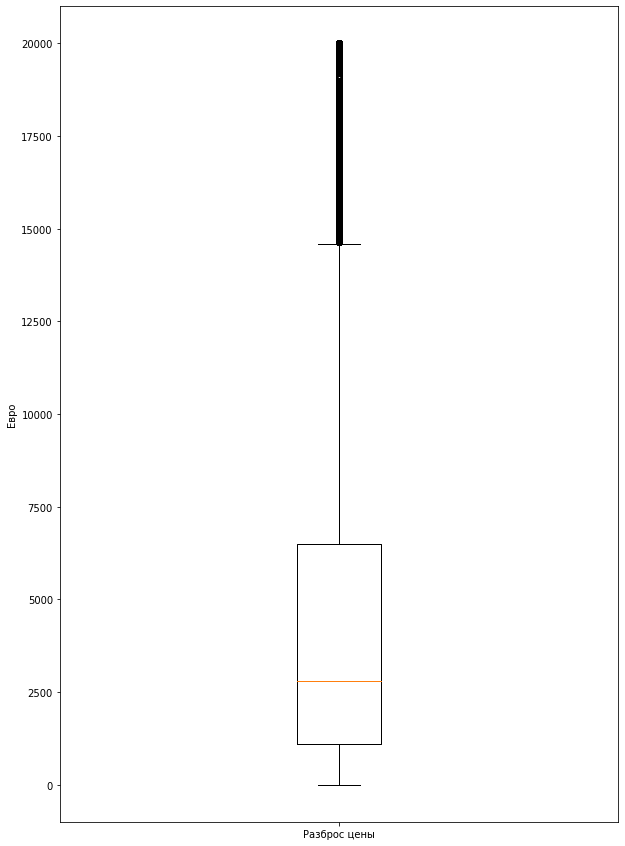

In [22]:
print(' Уникальные значения "price": ', data['price'].unique(), '\n')

fig, ax = plt.subplots(figsize = (10,15))

ax.boxplot(data['price'])

ax.set_xticklabels(['Разброс цены'])
ax.set_ylabel('Евро')
#ax.set_ylim([0,40000])

plt.show()

Оставим цены так, как есть. Возможно, машина не на ходу и поэтому стоит низкая цена ("Лишь бы забрали"), и также возможно, что машина старая и не на ходу, но при этом коллекционная и за нее просят относительно много.

In [23]:
print(' Уникальные значения "power": ', data['power'].unique(), '\n')


 Уникальные значения "power":  [    0   190   163    75    69   102   109    50   125   101   105   140
   115   131    60   136   160   231   118   193    99   113   218   122
   129    70   306    95    61   177   170    55   143   286   232   150
   156    80    82    90   155    54   185    87   180    86    84   224
   235   200   178   265    77   110   144   120   116   184   126   204
    88   194    64   305   197   179   250    45   313    41   165    98
   130   114   211    56   201   213    58   107    83   174   100   220
    73   192    68    66   299    74    52   147   310    71    97    65
   239   203     5   300   103    85   258   320    63    81   148    44
   145   230   280   260   104   188   333   186   117   141   132   234
   158    39    92    51   135    59    53   209    43   146    67   106
   166   276   344    72   249   237   245   111   326   279    23   138
   175    96   226    26    37   301   334   128   133   124    33   219
   241   167    94  

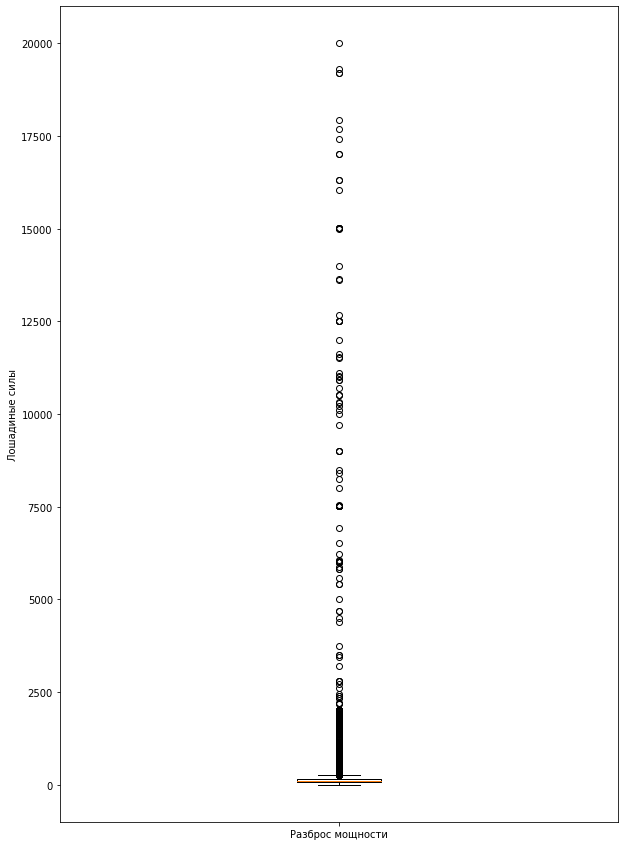

In [24]:
fig, ax = plt.subplots(figsize = (10,15))

ax.boxplot(data['power'])

ax.set_xticklabels(['Разброс мощности'])
ax.set_ylabel('Лошадиные силы')
#ax.set_ylim([0,40000])

plt.show()


Оставим только значения < 500

In [25]:
print(data.shape[0])
c = data['power'].quantile(q=0.75)
data = data.query('10<power<500')
print(data.shape[0])

print('75% квантиль', c)


     

339769
302631
75% квантиль 143.0


In [26]:
print(' Уникальные значения "kilometer": ', data['kilometer'].unique(), '\n')


 Уникальные значения "kilometer":  [125000 150000  90000  40000  30000  70000 100000  60000   5000  20000
  80000  50000  10000] 



Оставляем как есть.

In [27]:
print(' Уникальные значения "registrationmonth": ', data['registrationmonth'].unique(), '\n')


 Уникальные значения "registrationmonth":  [ 5  8  6  7 10  0 12 11  2  3  1  4  9] 



в таблице 13 уникальных значений вместо 12.

In [28]:
data['registrationmonth'].value_counts()

3     30835
6     28082
4     26173
5     26088
7     24271
10    23329
12    21593
11    21375
9     21295
1     20555
8     20108
0     19734
2     19193
Name: registrationmonth, dtype: int64

Определить нестыковку невозможно, поскольку определяющим является год, данный параметр исключим из рассмотрения как неопределяющий.

In [29]:
data=data.drop(['registrationmonth'], axis=1)
print(data.shape[0])

302631


In [30]:
data.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,1
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,1
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,1


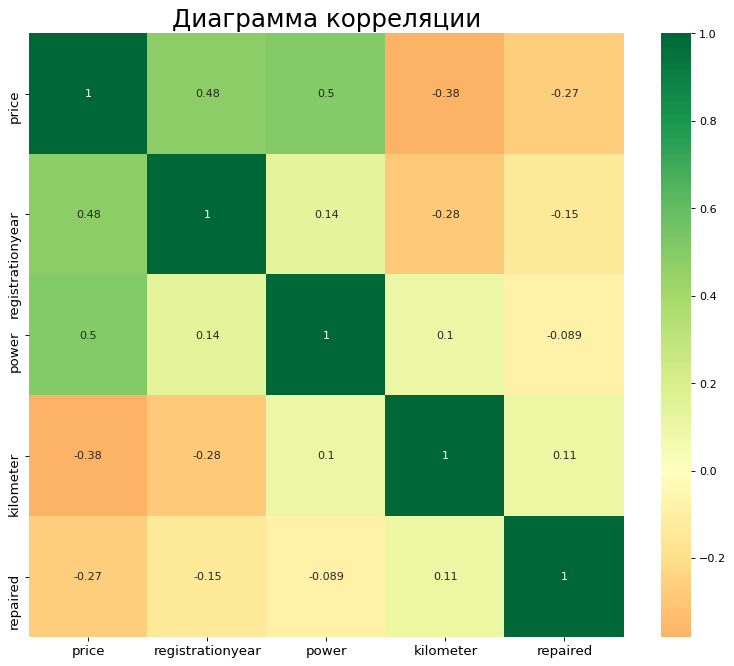

In [31]:
#Построим диаграмму корреляций
ds.corr_diagram(data)

По матрице корреляций наблюдается обратная зависимость цены с пробегом и ремонтом, прямая зависимость с мощностью и годом регистрации.

In [32]:
data.head(5)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302631 entries, 1 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             302631 non-null  int64 
 1   vehicletype       302631 non-null  object
 2   registrationyear  302631 non-null  int64 
 3   gearbox           302631 non-null  object
 4   power             302631 non-null  int64 
 5   model             302631 non-null  object
 6   kilometer         302631 non-null  int64 
 7   fueltype          302631 non-null  object
 8   brand             302631 non-null  object
 9   repaired          302631 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 25.4+ MB


## Обучение моделей

Разобьем имеющиеся данные на обучающую и тестовую выборку, a также установим значение random_state.
Удалим неинформативные признаки.

In [33]:
RND_ST = 42


In [34]:
#unnec_col = ['price', 'datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures', 'postalcode',
 #      'lastseen', 'monthcreated', 'yearcreated', 'gearboxunsorted']


In [35]:
features = data.drop('price', axis=1)
target = data['price']

In [36]:
features.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
1,coupe,2011,manual,190,other,125000,gasoline,audi,1
2,suv,2004,auto,163,grand,125000,gasoline,jeep,1
3,small,2001,manual,75,golf,150000,petrol,volkswagen,0
4,small,2008,manual,69,fabia,90000,gasoline,skoda,0
5,sedan,1995,manual,102,3er,150000,petrol,bmw,1


In [37]:

X_train_val, X_test, y_train_val, y_test = train_test_split(features, target, test_size=0.2, random_state=RND_ST)

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=RND_ST)


In [39]:
numeric =  ['registrationyear', 'power',
       'kilometer']

In [40]:
scaler = StandardScaler()

scaler.fit(X_train_val[numeric])

X_train_val[numeric] = scaler.transform(X_train_val[numeric])

X_test[numeric] = scaler.transform(X_test[numeric])

X_valid[numeric] = scaler.transform(X_valid[numeric])

/tmp/ipykernel_212/4180173306.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val[numeric] = scaler.transform(X_train_val[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_212/4180173306.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [42]:
ohe = OneHotEncoder(sparse=False)
num_cols =  ['registrationyear', 'power',
       'kilometer']
columns_cat=['brand','model','vehicletype','gearbox','fueltype','repaired']
ohe.fit(X_train_val[columns_cat])
X_train_val_cat = pd.DataFrame(ohe.transform(X_train_val[columns_cat]), 
                              columns=ohe.get_feature_names(columns_cat), index=X_train_val.index)
X_test_cat = pd.DataFrame(ohe.transform(X_test[columns_cat]), 
                              columns=ohe.get_feature_names(columns_cat), index=X_test.index)
X_valid_cat = pd.DataFrame(ohe.transform(X_valid[columns_cat]), 
                              columns=ohe.get_feature_names(columns_cat), index=X_valid.index)




По обучающей выборке определим валидационную.

In [44]:
print(X_train.shape[0], X_valid.shape[0], X_test.shape[0])

181578 60526 60527


**Dummy model**

В данном спринте разберем применение четырех моделей.
Но для начала вызовем Дамми регрессора, для дальнейшей проверки моделей на адекватность.
Передадим нашему первому регрессору средние значения цены.

Требуемая функция подсчета времени выполнения ячейки из задания представлена ниже.

In [46]:
%%time

dummy = DummyRegressor(strategy='mean')

dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_valid)

rmse_dr = np.around(np.sqrt(mean_squared_error(y_valid, y_pred)),3)
print('RMSE дамми регрессора со средним прогнозом цен на валидационной выборке = {}'.format(rmse_dr))
print()


RMSE дамми регрессора со средним прогнозом цен на валидационной выборке = 4582.505

CPU times: user 1.88 ms, sys: 566 µs, total: 2.44 ms
Wall time: 1.98 ms


Дамми ошибается, в среднем, на 4,6 тысячи Евро, однако, работает очень быстро.

**Создание скоринга RMSE**

На данном шаге мы сразу будем подбирать гиперпараметры и фиксировать лучшее значение метрики RMSE.

Пропишем этот скоринг с нуля

In [47]:
def rmse(targets, predictions):
    return np.sqrt(((predictions - targets) ** 2).mean())

RMSE_SCORE = make_scorer(rmse, greater_is_better=False)


Проверим его работу, вызовем простенький регрессор и попробуем найти гиперпараметры

In [45]:
features_ = data.drop('price', axis=1)
features_ = pd.get_dummies(features_, drop_first=True)
target_ = data['price']

In [46]:
X_train_val, X_test_, y_train_val, y_test_ = train_test_split(features_, target_, test_size=0.2, random_state=RND_ST)

In [47]:
#Стандартизируем признаки с помощью StandardScaler


In [48]:
numeric =  ['registrationyear', 'power',
       'kilometer']

In [49]:
scaler = StandardScaler()

scaler.fit(X_train_val[numeric])

X_train_val[numeric] = scaler.transform(X_train_val[numeric])

X_test[numeric] = scaler.transform(X_test[numeric])

X_valid[numeric] = scaler.transform(X_valid[numeric])

/tmp/ipykernel_212/4180173306.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val[numeric] = scaler.transform(X_train_val[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_212/4180173306.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [50]:


X_train_, X_valid_, y_train_, y_valid_ = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=RND_ST)

print(X_train_.shape[0], X_valid_.shape[0], X_test_.shape[0])


181578 60526 60527


In [55]:
X_train_.shape[1]

305

In [56]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=RND_ST)

dtr_params = dict(max_depth=[5,6,7], 
                 max_features=[2,3,4])


Функция рандомного поиска гиперпараметров

In [57]:
def rand_search(model, grid, feat, targ):
    
    search = RandomizedSearchCV(model, grid, cv=5, scoring=RMSE_SCORE, n_jobs=-1)
    search.fit(X_train_, y_train_)
    
    print(search.best_score_ * -1)
    print(search.best_params_)

In [58]:
rand_search(dtr, dtr_params, X_train_, y_train_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


3883.1584418245684
{'max_features': 4, 'max_depth': 7}


In [59]:
def rmse_score(model, X, y):
    
    y_pred = model.predict(X)

    score = rmse(y, y_pred)
    
    return(score)


Так судя по всему наш скоринг работает модель ошибается в среднем на 3,88 тысячи Евро, что немного лучше, чем Дамми модель.


Gradient Boosting

Начнем с обычного градиентного бустинга из sklearn.

Стоит отметить, что для его применения, необходимо перевести все категориальные показатели в числовые, используя dummy преобразование или OneHotEncoding

В идеале настроить бустинг в два этапа - на первом этапе подобрать количество деревьев, на втором - подогнать остальные параметры. Но Тренажер не обладает требуемой для быстрой работы мощностью.

In [61]:
gbr = GradientBoostingRegressor(random_state=RND_ST)

gbr_params_nest = dict(n_estimators=range(50,500,25))

gbr_params_other = dict(learning_rate=[0.1,0.5,1],
                        max_depth=[2,3,4])

In [63]:
%%time

gbr_1 = GradientBoostingRegressor(random_state=RND_ST, n_estimators=250, learning_rate=0.1, max_depth=3, verbose=50)
gbr_1.fit(X_train_, y_train_)


      Iter       Train Loss   Remaining Time 
         1    19011127.1169            3.84m
         2    17067217.3474            3.70m
         3    15446256.9580            3.67m
         4    14085149.2278            3.64m
         5    12869379.7327            3.58m
         6    11916705.1817            3.56m
         7    11050330.7861            3.54m
         8    10333995.0772            3.53m
         9     9704456.8631            3.50m
        10     9121739.3442            3.46m
        11     8665106.4591            3.43m
        12     8236443.5423            3.41m
        13     7891966.9761            3.40m
        14     7560419.4648            3.38m
        15     7237479.9782            3.36m
        16     7005500.3721            3.34m
        17     6761312.3970            3.31m
        18     6536722.5398            3.30m
        19     6351956.7344            3.30m
        20     6189598.2104            3.28m
        21     6051085.8700            3.27m
        2

GradientBoostingRegressor(n_estimators=250, random_state=42, verbose=50)

In [64]:
%%time
print('RMSE на обучающей выборке', rmse_score(gbr_1, X_train_, y_train_))
print()


RMSE на обучающей выборке 1877.7126704140378

CPU times: user 1.72 s, sys: 243 ms, total: 1.97 s
Wall time: 1.98 s


In [65]:
%%time
print('RMSE на валидационной выборке', rmse_score(gbr_1, X_valid_, y_valid_))
print()

RMSE на валидационной выборке 1859.2877718136094

CPU times: user 483 ms, sys: 67.8 ms, total: 550 ms
Wall time: 554 ms


Без особого подбора гиперпараметров удалось на валидационной выборке улучшить качество, относительно первоначального, до 1906.20 Евро (метрика RMSE). Посмотрим, что смогут сделать другие модели.


**Итог GradientBoosting**

Обучение - 214 сек

Предсказание на валидации - 681 мсек

RMSE на валидации - 1859.24

Переобучения не обнаружено.

In [66]:
res = {
    'model_name':pd.Series(['GradBoost','xgboost','lightGBM','CatBoost']),
    'training_time':pd.Series([214,0,0,0]),
    'prediction_valid_time':pd.Series([681,0,0,0]), 
    'rmse_valid':pd.Series([1859.24,0,0,0]), 
  }

In [67]:
results = pd.DataFrame(res)
results

,model_name,training_time,prediction_valid_time,rmse_valid
0,GradBoost,214,681,1859.24
1,xgboost,0,0,0.00
2,lightGBM,0,0,0.00
3,CatBoost,0,0,0.00


**XGboost**

In [68]:
dtrain = xgb.DMatrix(X_train_, label=y_train_)
dval = xgb.DMatrix(X_valid_)
dtest = xgb.DMatrix(X_test_)

In [69]:
%%time
param = {'max_depth':3, 
         'eta':1, 
         'sampling_method':'gradient_based', 
         'verbosity':1, 
         'gamma':10, 
         'seed':RND_ST}

num_round = 30

bst = xgb.train(param, dtrain, num_round)


CPU times: user 49.4 s, sys: 0 ns, total: 49.4 s
Wall time: 49.4 s


In [70]:
%%time
print('RMSE на обучающей выборке', rmse_score(bst, dtrain, y_train_))
print()

RMSE на обучающей выборке 2001.7341407696356

CPU times: user 281 ms, sys: 0 ns, total: 281 ms
Wall time: 299 ms


In [71]:
%%time
print('RMSE на валидационной выборке', rmse_score(bst, dval, y_valid_))
print()


RMSE на валидационной выборке 1986.3298446822293

CPU times: user 106 ms, sys: 0 ns, total: 106 ms
Wall time: 89 ms


Изменим параметры

In [72]:
%%time
param = {'max_depth':6, 
         'eta':0.5, 
         'min_child_weight':4,
         'sampling_method':'gradient_based', 
         'verbosity':1,  
         'seed':RND_ST}

num_round = 35

bst = xgb.train(param, dtrain, num_round)



CPU times: user 1min 42s, sys: 0 ns, total: 1min 42s
Wall time: 1min 43s


In [73]:
%%time
print('RMSE на обучающей выборке', rmse_score(bst, dtrain, y_train_))
print()


RMSE на обучающей выборке 1732.8582464055678

CPU times: user 389 ms, sys: 0 ns, total: 389 ms
Wall time: 387 ms


In [74]:
%%time
print('RMSE на валидационной выборке', rmse_score(bst, dval, y_valid_))
print()

RMSE на валидационной выборке 1772.3750013363472

CPU times: user 149 ms, sys: 0 ns, total: 149 ms
Wall time: 185 ms


Удалось улучшить RMSE на валидационной выборке, в сравнении с Gradient boosting.
Заметно улучшилось время обучения и предсказания.

In [75]:
results.loc[1,'training_time'] = 123
results.loc[1,'prediction_valid_time'] = 162
results.loc[1,'rmse_valid'] = 1772.37
results

,model_name,training_time,prediction_valid_time,rmse_valid
0,GradBoost,214,681,1859.24
1,xgboost,123,162,1772.37
2,lightGBM,0,0,0.00
3,CatBoost,0,0,0.00


# **Итог xgbost**

Обучение - 107 сек

Предсказание на валидации - 162 мсек

RMSE на валидации - 1772.34	


**LightGBM**

Переводим категориальные признаки из 'str' в 'int'

In [76]:
features_light = features.copy()
features.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
1,coupe,2011,manual,190,other,125000,gasoline,audi,1
2,suv,2004,auto,163,grand,125000,gasoline,jeep,1
3,small,2001,manual,75,golf,150000,petrol,volkswagen,0
4,small,2008,manual,69,fabia,90000,gasoline,skoda,0
5,sedan,1995,manual,102,3er,150000,petrol,bmw,1


In [77]:
features_light.columns

Index(['vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'fueltype', 'brand', 'repaired'],
      dtype='object')

In [78]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

In [80]:
cat_feat = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']

features_light[cat_feat] = enc.fit_transform(features_light[cat_feat]).astype('int')


In [81]:
features_light.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
1,2,2011,1,190,166,125000,2,1,1
2,6,2004,0,163,117,125000,2,14,1
3,5,2001,1,75,116,150000,6,38,0
4,5,2008,1,69,101,90000,2,31,0
5,4,1995,1,102,11,150000,6,2,1


Создаем три подвыборки.

In [82]:
X_train_val_l, X_test_l, y_train_val_l, y_test_l = train_test_split(
    features_light, target, test_size=0.2, random_state=RND_ST)

 
X_train_l, X_valid_l, y_train_l, y_valid_l = train_test_split(
    X_train_val_l, y_train_val_l, test_size=0.25, random_state=RND_ST)


print(X_train_l.shape[0], X_valid_l.shape[0], X_test_l.shape[0])


181578 60526 60527


In [84]:
train_data = lgb.Dataset(X_train_l, y_train_l, categorical_feature=cat_feat)
valid_data = lgb.Dataset(X_valid_l, categorical_feature=cat_feat) 
test_data = lgb.Dataset(X_test_l, categorical_feature=cat_feat)

Укажем первичные параметры.

In [85]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    #'max_depth':15,
    'num_leaves': 127,
    'min_data_in_leaf':100,
    'metric':'rmse',
    'learning_rate': 1,
    #'feature_fraction': 0.8,
    #'bagging_fraction': 0.5,
    'verbose': 1
}

In [86]:
%%time
gbm = lgb.train(params,
                train_data,
                num_boost_round=30)


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 621
[LightGBM] [Info] Number of data points in the train set: 181578, number of used features: 9
[LightGBM] [Info] Start training from score 4766.730364
CPU times: user 3.31 s, sys: 0 ns, total: 3.31 s
Wall time: 3.27 s


In [87]:
%%time
print('RMSE на обучающей выборке', rmse_score(gbm, X_train_l, y_train_l))
print()

RMSE на обучающей выборке 1583.6410921119611

CPU times: user 822 ms, sys: 0 ns, total: 822 ms
Wall time: 801 ms


In [88]:
%%time
print('RMSE на валидационной выборке', rmse_score(gbm, X_valid_l, y_valid_l))
print()

RMSE на валидационной выборке 1774.900520397702

CPU times: user 283 ms, sys: 0 ns, total: 283 ms
Wall time: 298 ms


Cкорость обучения и rmse на валидационной выборке лучше предыдущиx двух моделей.

In [89]:
results.loc[2,'training_time'] = 2.88 
results.loc[2,'prediction_valid_time'] = 309
results.loc[2,'rmse_valid'] = 1774.90



In [90]:
results

,model_name,training_time,prediction_valid_time,rmse_valid
0,GradBoost,214.00,681,1859.24
1,xgboost,123.00,162,1772.37
2,lightGBM,2.88,309,1774.90
3,CatBoost,0.00,0,0.00


## **Итог LightGBM**

Обучение - 2.88	 сек

Предсказание на валидации - 309	 мсек

RMSE на валидации - 1821.22

**CatBoost**

Категориальные фичи-значения ('str') теперь можно не переводить в цифровые!

Снова создаем три подвыборки.

In [91]:
X_train_val_c, X_test_c, y_train_val_c, y_test_c = train_test_split(
    features, target, test_size=0.2, random_state=RND_ST)

 
X_train_c, X_valid_c, y_train_c, y_valid_c = train_test_split(
    X_train_val_c, y_train_val_c, test_size=0.25, random_state=RND_ST)


print(X_train_c.shape[0], X_valid_c.shape[0], X_test_c.shape[0])



181578 60526 60527


In [92]:
X_train_c.columns

Index(['vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'fueltype', 'brand', 'repaired'],
      dtype='object')

Создаем три пула.

In [93]:
train_pool = Pool(X_train_c, 
                  y_train_c, 
                  cat_features=cat_feat)

valid_pool = Pool(X_valid_c, 
                  y_valid_c, 
                  cat_features=cat_feat)

test_pool = Pool(X_test_c, 
                 cat_features=cat_feat) 


Обучаем модедь.

In [94]:
cbr = CatBoostRegressor(depth=6, 
                        learning_rate=1, 
                        loss_function='RMSE', 
                        verbose=50, 
                        random_state=RND_ST, 
                        iterations=500)


In [95]:
%%time
cbr.fit(train_pool)


0:	learn: 2702.6832312	total: 240ms	remaining: 1m 59s
50:	learn: 1767.8764865	total: 6.74s	remaining: 59.3s
100:	learn: 1699.7856550	total: 13.1s	remaining: 51.8s
150:	learn: 1652.7819025	total: 19.2s	remaining: 44.3s
200:	learn: 1622.4777631	total: 25.5s	remaining: 38s
250:	learn: 1598.1934015	total: 32s	remaining: 31.7s
300:	learn: 1577.5341833	total: 38.6s	remaining: 25.5s
350:	learn: 1559.1930270	total: 44.9s	remaining: 19.1s
400:	learn: 1542.9736889	total: 51s	remaining: 12.6s
450:	learn: 1528.7559179	total: 57.1s	remaining: 6.21s
499:	learn: 1515.5572179	total: 1m 3s	remaining: 0us
CPU times: user 1min 4s, sys: 0 ns, total: 1min 4s
Wall time: 1min 5s


In [96]:
%%time
print('RMSE на обучающей выборке', rmse_score(cbr, X_train_c, y_train_c))
print()


RMSE на обучающей выборке 1548.7182161420778

CPU times: user 1.21 s, sys: 10.6 ms, total: 1.22 s
Wall time: 1.23 s


In [97]:
%%time
print('RMSE на валидационной выборке', rmse_score(cbr, X_valid_c, y_valid_c))
print()

RMSE на валидационной выборке 1712.6685004930973

CPU times: user 403 ms, sys: 8.17 ms, total: 411 ms
Wall time: 420 ms


Попробуем еще понастраивать параметры.

In [98]:
cbr_1 = CatBoostRegressor(depth=7, 
                        learning_rate=0.1, 
                        loss_function='RMSE', 
                        verbose=50, 
                        l2_leaf_reg=10,
                        random_state=RND_ST, 
                        iterations=400)

In [ ]:
%%time
cbr_1.fit(train_pool)


0:	learn: 4321.6479287	total: 208ms	remaining: 1m 22s
50:	learn: 1906.7717043	total: 8.24s	remaining: 56.4s
100:	learn: 1819.0136781	total: 15.2s	remaining: 44.9s
150:	learn: 1778.7581670	total: 22.5s	remaining: 37s
200:	learn: 1751.3808152	total: 29.7s	remaining: 29.4s


In [ ]:
%%time
print('RMSE на обучающей выборке', rmse_score(cbr_1, X_train_c, y_train_c))
print()


In [ ]:
%%time
print('RMSE на валидационной выборке', rmse_score(cbr_1, X_valid_c, y_valid_c))
print()


In [ ]:
results.loc[3,'training_time'] = 61
results.loc[3,'prediction_valid_time'] = 244
results.loc[3,'rmse_valid'] = 1699.58

In [ ]:
results

# **Итог CatBoost**

Обучение - 62 сек

Предсказание на валидации - 226 мсек

RMSE на валидации - 1746.49	

Заметно переобучение.

**Вывод**

На данном шаге было проведено тестирование пяти моделей:

Дамми

Градиентный бустинг sklearn

xgboost

LightGBM

CatBoost

Быстрее всех учится и предсказывает xgboost, занимая при этом второе место по качеству предсказаний. 

Наилучшую метрику rmse на валидационной выборке показал CatBoost, однако время его предсказаний - второе из всех моделей.

В целом, сейчас уже можно выбросить из конкурса GradientBoosting, однако, произведем замеры rmse всех моделей на тестовой выборке.

## Анализ моделей

На данном этапе определим метрику rmse лучшей модели CatBoost на оставшейся тестовой выборке.

In [ ]:
%%time
print('RMSE CatBoost на тестовой выборке', rmse_score(cbr_1, X_test_c, y_test_c))
print()

In [ ]:
results.loc[0,'prediction_test_time'] = ' '
results.loc[0,'rmse_test'] = ' '

results.loc[1,'prediction_test_time'] = ' '
results.loc[1,'rmse_test'] = ' '

results.loc[2,'prediction_test_time'] = ' '
results.loc[2,'rmse_test'] = ' '

results.loc[3,'prediction_test_time'] = 254
results.loc[3,'rmse_test'] = 1718.84


In [ ]:
results

**Вывод.**

Все обученные модели смогли улучшить RMSE базовой модели.

Лучший результат RMSE показала модель CatBoost 1768.66. Худший - модель GradBoost 1922.72.

Лучший результат по времени показала модель xgboost	.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей